In [1]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data, split_branches, get_model, set_pretrained_model_dropout, get_dataset, ModelSeeder
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import time
import onnx
import logging
from onnx_model_manager import OnnxModelManager
from onnxruntime.quantization import quantize_dynamic, QuantType
import os
import datasets
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM
from model_manager import ModelManager

In [2]:
# seed = random.randint(0, 2 ** 32 - 1)
seed = 3218885689
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 3218885689


In [3]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [4]:
config = {
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 200
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 0,
    #"to_freeze_gpt_blocks": 11,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)

In [5]:
saved_model_path = os.path.join("models", "awsw_main")
if os.path.exists(os.path.join(saved_model_path, "pytorch_model.bin")):
    tokenizer = AutoTokenizer.from_pretrained('EleutherAI/gpt-neo-125M')
    model = AutoModelForCausalLM.from_pretrained(saved_model_path)
    print("Pretrained model loaded")
else:
    model, tokenizer = get_model("EleutherAI/gpt-neo-125M")
    print("Loaded empty model")
model.to(device)
# set_pretrained_model_dropout(model.transformer.h[-1:], 0.05)

Loaded empty model


GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0, inplace=False)
            (resid_dropout): Dropout(p=0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, o

# Test before training on a pretrained model!

In [6]:
model.eval()
model_manager = ModelManager(model=model, tokenizer=tokenizer, device=device)
def test_regular_sampler():
    print(model_manager.say_raw("In my dreams, I'm a dragon", 50, 0.7))
test_regular_sampler()

In my dreams, I'm a dragon-slayer. I'm a dragon, a dragon, a dragon, a dragon, a dragon, a dragon. My dream is that I will live and die in my dreams, a dragon, a dragon, a dragon, a dragon.

I am the dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a dragon-slayer, a


# Reviewing our dataset!

In [7]:
dataset = get_dataset(tokenizer, path_train = os.path.join(Config.work_dir, "data_train.txt"))
print("Dataset demo snapshot:")
for item in dataset['train']:
    print(tokenizer.decode(item['input_ids']))
    break

print("RP review!")
has_seen_rp = False
for item in dataset['train']:
    decoded = tokenizer.decode(item['input_ids'])
    if 'c "Fight ' in decoded: 
        print(decoded)
        has_seen_rp = True
        continue        
    if has_seen_rp:
        print(decoded)
        break
# Clean up
del has_seen_rp
# dataset['model_seeder'].stop_worker()
# del dataset

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset demo snapshot:


Token indices sequence length is longer than the specified maximum sequence length for this model (2083 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


<d><scn>black<msg>Lo "Now that we're here, I can tell you that no expense will be spared to make our portrayal of humans as accurate as possible."<|endoftext|><p><msg>c "(Pun intended?)"<|endoftext|><d><scn>bare<msg>Br "Just the usual."<|endoftext|><d><scn>loremapt<msg>Ip "As a scientist, my professional opinion is that this part looks a little long."<|endoftext|><d><scn>o2<msg>Ad "I disagree with that."<|endoftext|><p><msg>c "
RP review!


Token indices sequence length is longer than the specified maximum sequence length for this model (2159 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (3376 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2085 > 2048). Running this sequence through the model will result in indexing errors


><msg>c "Just kidding. Go ahead."<|endoftext|><p><msg>c "Fight Adine"<d><scn>beach<msg>m "Adine barely avoids my attack and fell, but managed to get up and quickly punch me in the face, a soaring pain quickly came over my face"<|endoftext|>at the last second" is meant in a literal sense here, or else she could've just called me.)"<|endoftext|><p><msg>c "#2, the room filled with one hundred highly trained assassins."<|endoftext|><d><scn>cafe<msg>An "I'll have
 a coffee."<|endoftext|><p><msg>c "Sure."<d><scn>loremapt<msg>m "We sat down at the coffee table. Lorem opened up a laptop and started to type away."<d><scn>loremapt<msg>m "Seeing the laptop brought back memories. In our world, they had become obsolete a long time ago."<d><scn>loremapt<msg>Lo "Before I show you these images, I should probably tell you that some of them are really weird. Just don't take them the wrong way."<|endoftext|><d><


# Training

Model is put in training mode and we begin training. The `train_results` will contain all data after training is completed.

In [8]:
train_results = {}
model.train()
train_model(model, tokenizer, dataset, config, train_results)

[0] set freeze_part_layers: True (freezing 0 out of 160 layers.)


Step,Training Loss
214,73559.266400
428,461421.719600
642,931676.336400
856,1258225.046700
1070,1524205.607500
1284,1802830.205600
1498,2088489.420600
1712,2353130.317800
1926,2637141.233600
2140,2960561.345800


KeyboardInterrupt: 

KeyError: 'learning_rate_history'

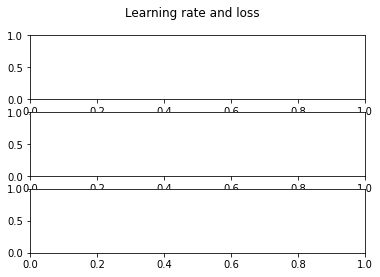

In [9]:
fig, axs = plt.subplots(3)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['model_closeness_loss'])
axs[2].plot(train_results['loss_history'])

In [10]:
model.eval()
model.save_pretrained(saved_model_path)

# Conversion to ONNX
ONNX is a different format for running machine learning models. The ONNX format is much faster on CPU, sometimes 5 times as fast as PyTorch!

While the EAWSW model is designed to be small, accurate and accessible, for some people it's still too much to run...

Hosting the model as a free service for players is an option. An ONNX version of the model allows us to host the model on CPU yet have faster response times! Given that the model is made in a time with chip shortage, running on hardware I already have inside a server is efficient, scalable and cheaper.

An important note is that ONNX doesn't execute logic by itself, and you have to do that yourself, `onnx_model_manager.py` intends to deal with this for us.

In [ ]:
saved_model_onnx_path = os.path.join("models", "awsw_onnx")
if not os.path.exists(os.path.join(saved_model_path, "special_tokens_map.json")):
    print("Copying config files from huggingface (needed for conversion)... WARNING: this assumes the structure of the model isn't changed!")
    !cd $saved_model_path && git clone https://huggingface.co/EleutherAI/gpt-neo-125M
    !cp -n $saved_model_path/gpt-neo-125M/* $saved_model_path
    !rm -rf $saved_model_path/gpt-neo-125M
if not os.path.exists(os.path.join(saved_model_onnx_path, "model.onnx")):
    !python3 -m transformers.onnx --model=$saved_model_path --feature=causal-lm-with-past $saved_model_onnx_path

In [ ]:
def optimize_onnx():
    model_quant = os.path.join(saved_model_onnx_path, "model_quant.onnx")
    if not os.path.exists(model_quant):
        model_fp32 = os.path.join(saved_model_onnx_path, "model.onnx")
        model_opt = os.path.join(saved_model_onnx_path, "model-opt.onnx")
        quantized_model = quantize_dynamic(model_fp32, model_quant, weight_type=QuantType.QUInt8)
        #!rm $model_opt
optimize_onnx()

In [ ]:
onnx_model_manager = OnnxModelManager(os.path.join(saved_model_onnx_path, "model.onnx"))

In [ ]:
prompt = "In my dreams, I'm a dragon"
for i in range(10):
    print("ONNX:", onnx_model_manager.say_raw(prompt, do_sample=True))
    print("PyTorch:", model_manager.say_raw(prompt, 50, 0.7))
    print('-' * 100)

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.
The first test involves a old prompt to compare the pre-trained model with the one trained on AWSW. Did it manage to store it's data well? Is it able to write down things that have nothing to do with AWSW? (So we know we didn't overfit).

In [11]:
test_regular_sampler()

In my dreams, I'm a dragon. You need everything to be done for you by an army of lackeys and cooks."<|endoftext|>


**This test generates boring and repetetive** replies! It's because we use no good sampling algorithm, but it does give us a indication of what the model has learned!

In [12]:
prompts = [
    ('<p><msg>c "Hey Remy!"<d><scn>park2<msg>Ry "Hey!"', "How are you?"),
    ('<p><msg>c "I was with Lorem today."<d><scn>park2<msg>Ad "Very nice."', "What do you think of Lorem?"),
    ('<p><msg>m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('<p><msg>m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

def sample_test(model_manager):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt)
        print(f"Prompt: {prompt}\nReply: {reply}\n\n")
print("Test Pytorch...")
start = time.time()
sample_test(model_manager)
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
start = time.time()
sample_test(onnx_model_manager)
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

Test Pytorch...
Prompt: How are you?
Reply: park2<msg>Ry "I'm beginning to realize that maybe it's not their fault. Maybe it's me."<d><scn>park2<msg>Ry "Goodbye, [player_name]."<|endoftext|>


Prompt: What do you think of Lorem?
Reply: loremapt<msg>Ip "This apartment was actually intended to house one dragon of a bigger size. That not only makes it fairly cheap, but it's also big enough for both of us."<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: black<msg>Ad "Do you like your Mouflon à la Anna?"<p><msg>c "I feel like a wild animal."<d><scn>black<msg>An "Quite different from sitting in an expensive restaurant and using their fancy cutlery and napkins, isn't it?"<p><msg>c "Yeah, I like it."<|endoftext|>


Prompt: What will we do here?
Reply: facin2<msg>An "I could show you sometime, but we're here to have fun, right?"<p><msg>c "I thought you wanted to show me, since you said we were both in biology and all that."<d><scn>facin2<msg>An "Sure, but after doing this all day

NameError: name 'onnx_model_manager' is not defined

# Sampling test

This is gonna be interesting!

In [ ]:
print("Test Pytorch...")
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = 50, top_p = 0.7)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
pytorch_time = end - start
print("Test ONNX...")
logging.basicConfig(level=logging.DEBUG)
start = time.time()
for i in range(1):
    for (past, prompt) in prompts:
        reply = onnx_model_manager.say(past, prompt, do_sample = True)
        print(f"[Test {i + 1}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")
end = time.time()
onnx_time = end - start
print(f"PyTorch on {device} took {pytorch_time:.4f} seconds")
print(f"ONNX on CPU took {onnx_time:.4f} seconds")

# RP test
Testing out the injected roleplay actions

In [ ]:
test_rps = [
    "Visit Lorem",
    "Meet with Lorem",
    "Visit Adine",
    "Fight Maverick",
    "Fight Adine",
    "Attack Adine"
]
for rp in test_rps:
    print(f'{rp} -> {model_manager.say("", rp, top_k = 50, top_p = 0.7)}')